[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of tricks for trimming or filtering messages in graph state. 

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases. 

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")



## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [3]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [4]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [5]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [6]:
from langchain_aws import ChatBedrock   

from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatBedrock(model_id="us.amazon.nova-pro-v1:0", temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

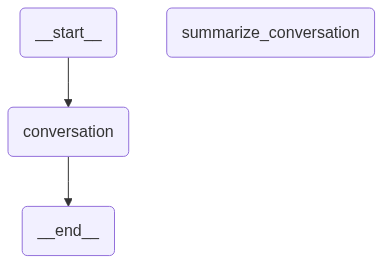

In [7]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times. 

In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello again, Lance! It's good to have you back. We've already touched on your enthusiasm for the 49ers. If there's anything specific you'd like to discuss further about the team or any other topic, please feel free to share. I'm here to help with whatever you're interested in!
================================== Ai Message ==================================

You've mentioned that your name is Lance. It's great to reconnect with you, Lance. If you have any questions or topics you'd like to discuss, whether it's about the 49ers, another subject, or just sharing more about your interests, I'm here to assist. What would you like to talk about today?
================================== Ai Message ==================================

It's wonderful to hear that you're a fan of the San Francisco 49ers! Their history is rich with memorable moments, legendary players, and exciting games. If you're interested, we coul

Let's confirm that our state is saved locally.

In [9]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='bd659476-cc0a-471f-94d8-e5892aad5028'), AIMessage(content="Hello again, Lance! It's good to have you back. We've already touched on your enthusiasm for the 49ers. If there's anything specific you'd like to discuss further about the team or any other topic, please feel free to share. I'm here to help with whatever you're interested in!", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '536187b9-b94f-49ce-a8b8-cbf0136cef87', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 09 Jun 2025 15:33:33 GMT', 'content-type': 'application/json', 'content-length': '460', 'connection': 'keep-alive', 'x-amzn-requestid': '536187b9-b94f-49ce-a8b8-cbf0136cef87'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [606]}, 'model_name': 'us.amazon.nova-pro-v1:0'}, id='run--3ab26adc-9252-429c-814a-46b4461c06e4-0', usage_metadata={'input_

In [10]:
graph.get_state(config).values.get("summary","")

"Here's the extended summary incorporating the new messages:\n\nLance introduced himself twice during the conversation, expressing his fondness for the San Francisco 49ers football team each time. The AI assistant acknowledged Lance's name and enthusiasm for the 49ers, consistently showing a willingness to engage in a deeper discussion about the team. The AI offered to talk about various aspects of the 49ers, such as their history, current roster, memorable games, or any specific details Lance might be curious about. Despite the conversation being brief and somewhat repetitive, with Lance reintroducing himself and reiterating his interest in the 49ers without directly responding to the AI's questions or prompts for more specific discussion points, the AI assistant maintained a friendly and helpful tone. It continued to encourage Lance to share more about what he'd like to discuss regarding the 49ers or any other topic of interest, demonstrating patience and openness to engage in a more

### Persisting state

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


In [11]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='bd659476-cc0a-471f-94d8-e5892aad5028'), AIMessage(content="Hello again, Lance! It's good to have you back. We've already touched on your enthusiasm for the 49ers. If there's anything specific you'd like to discuss further about the team or any other topic, please feel free to share. I'm here to help with whatever you're interested in!", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': '536187b9-b94f-49ce-a8b8-cbf0136cef87', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 09 Jun 2025 15:33:33 GMT', 'content-type': 'application/json', 'content-length': '460', 'connection': 'keep-alive', 'x-amzn-requestid': '536187b9-b94f-49ce-a8b8-cbf0136cef87'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [606]}, 'model_name': 'us.amazon.nova-pro-v1:0'}, id='run--3ab26adc-9252-429c-814a-46b4461c06e4-0', usage_metadata={'input_

## LangGraph Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.